# **Convolution Assignment**


### Uploading Kaggle API File and Downloading Dogs vs Cats dataset from Kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"golisaipriyanka","key":"9468262d147bd3b07c697da71a59b21e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 97% 789M/812M [00:12<00:00, 71.8MB/s]
100% 812M/812M [00:12<00:00, 67.1MB/s]


### Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?




**Creating and Copying dataset to test, train and validation directory**

In [5]:
import os, shutil, pathlib
d_dir = pathlib.Path("train")
n_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = n_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = d_dir / fname
            dst = dir / fname
            shutil.copyfile(src, dst)

make_subset("train", start_index=500, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

**Building a basic model to classify dogs and cats using convolutional neural networks**

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(n_dir / "train",image_size=(180, 180),batch_size=32)

valid_data = image_dataset_from_directory(n_dir / "validation",image_size=(180, 180),batch_size=32)

test_data= image_dataset_from_directory(n_dir / "test",image_size=(180, 180),batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Create an instance of the dataset using a NumPy array that has 1000 random samples with a vector size of 16**

In [7]:
import numpy as np
import tensorflow as tf

run_num = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(run_num)
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
       break

batch_data = dataset.batch(32)
for i, element in enumerate(batch_data):
    print(element.shape)
    if i >= 2:
       break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
       break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the Dataset**


In [8]:
for dataset_batch, label_batch in train_data:
    print("data batch shape:", dataset_batch.shape)
    print("labels batch shape:", label_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Identifying a small convolution for dogs vs. cats categories**

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

input_1000 = keras.Input(shape=(180, 180, 3))
dat = layers.Rescaling(1./255)(input_1000)
dat = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(dat)
dat = layers.Flatten()(dat)
dat = layers.Dropout(0.5)(dat)
output_1000 = layers.Dense(1, activation="sigmoid")(dat)
model = keras.Model(inputs=input_1000, outputs=output_1000)

**Model Training**

In [10]:
model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])

**The training dataset is used to train the model after it has been built. We use the validation dataset to verify the model's performance at the end of each epoch. I'm utilizing T4 GPU to reduce the time it takes for each epoch to execute**

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

**Model Fitting**

In [12]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(train_data,
epochs=100,
validation_data=valid_data,
callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 15s 102ms/step - loss: 0.6950 - accuracy: 0.5025 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 58ms/step - loss: 0.6928 - accuracy: 0.5205 - val_loss: 0.7050 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6943 - accuracy: 0.4885 - val_loss: 0.6893 - val_accuracy: 0.5670
Epoch 4/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6938 - accuracy: 0.4970 - val_loss: 0.6912 - val_accuracy: 0.5010
Epoch 5/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6883 - accuracy: 0.5140 - val_loss: 0.6851 - val_accuracy: 0.5470
Epoch 6/100
63/63 [==============================] - 4s 58ms/step - loss: 0.6747 - accuracy: 0.5655 - val_loss: 0.6864 - val_accuracy: 0.6300
Epoch 7/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6688 - accuracy: 0.5985 - val_loss: 0.6970 - val_accuracy: 0.5240
Epoc

**Curves of loss and accuracy during training**





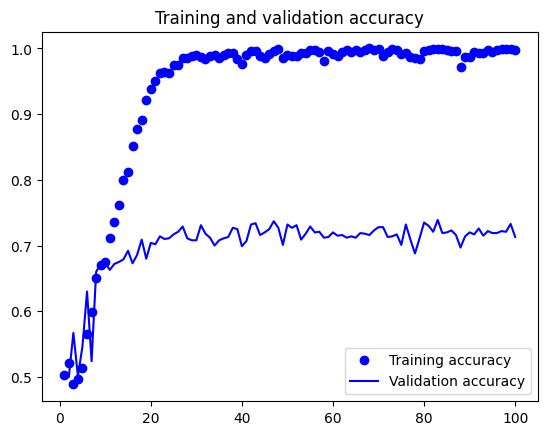

<Figure size 640x480 with 0 Axes>

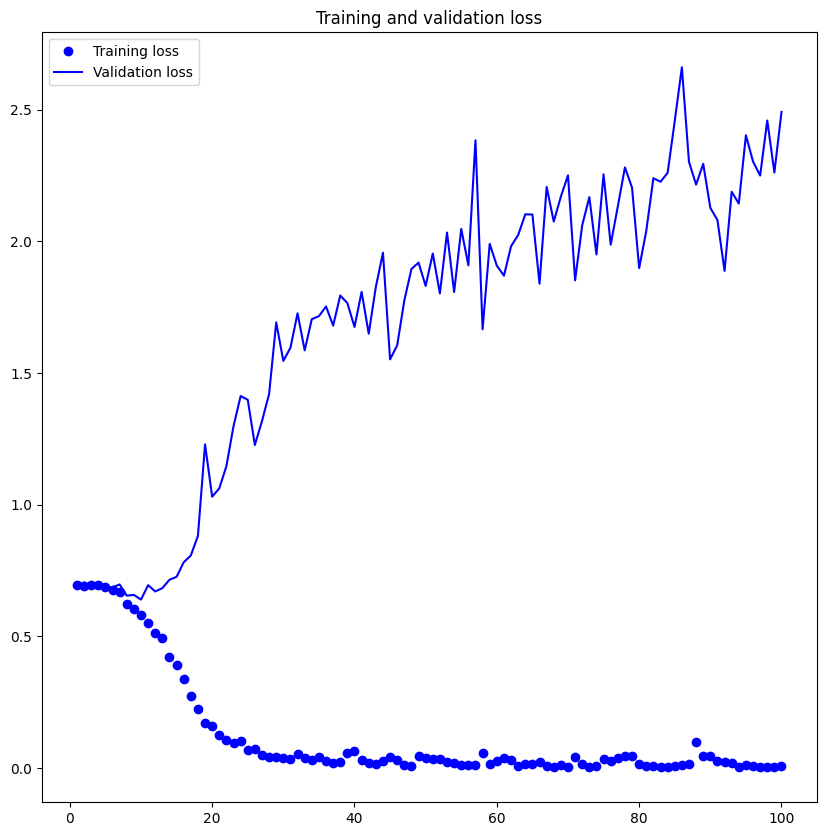

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Test Accuracy of model**

In [14]:
test = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.6191 - accuracy: 0.6770
Test accuracy: 0.677


### Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

**Using data augmentation**

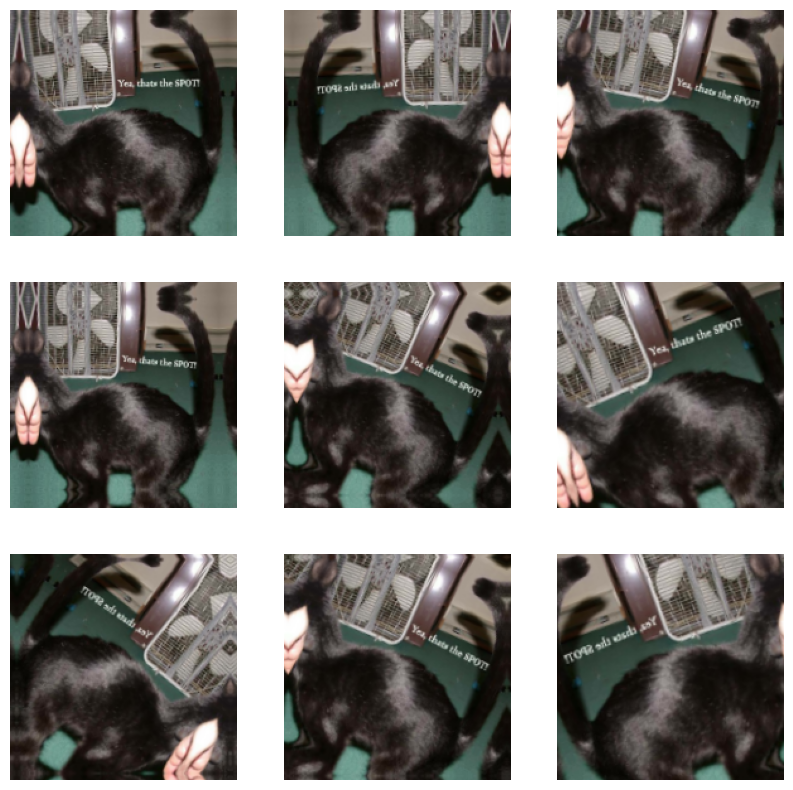

In [15]:
shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)
org_dir= pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=org_dir / fname,
            dst=dir / fname)

make_subset("train", start_index=667, end_index=2167)
make_subset("validation", start_index=2168, end_index=2668)
make_subset("test", start_index=2669, end_index=3168)
augmentation_info = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = augmentation_info(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Convolutional neural network with dropout and picture augmentation**

In [16]:
input = keras.Input(shape=(180, 180, 3))
data = augmentation_info(input)
data = layers.Rescaling(1./255)(data)
data= layers.Conv2D(filters=32, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data= layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data)
data= layers.Flatten()(data)
data = layers.Dropout(0.5)(data)
output = layers.Dense(1, activation="sigmoid")(data)
model = keras.Model(inputs=input, outputs=output)
model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])
callbacks= [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation_info.keras",
save_best_only=True,
monitor="val_loss")
]
hist = model.fit(
train_data,
epochs=50,
validation_data=valid_data,
callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 94ms/step - loss: 0.6980 - accuracy: 0.4870 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6904 - accuracy: 0.5190 - val_loss: 0.6974 - val_accuracy: 0.5100
Epoch 3/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6906 - accuracy: 0.5195 - val_loss: 0.6844 - val_accuracy: 0.5390
Epoch 4/50
63/63 [==============================] - 4s 59ms/step - loss: 0.6912 - accuracy: 0.5140 - val_loss: 0.6905 - val_accuracy: 0.5130
Epoch 5/50
63/63 [==============================] - 4s 61ms/step - loss: 0.6912 - accuracy: 0.5145 - val_loss: 0.6918 - val_accuracy: 0.5160
Epoch 6/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6890 - accuracy: 0.5270 - val_loss: 0.6828 - val_accuracy: 0.5420
Epoch 7/50
63/63 [==============================] - 5s 77ms/step - loss: 0.6816 - accuracy: 0.5660 - val_loss: 0.6916 - val_accuracy: 0.5720
Epoch 8/50


**Curves of loss and accuracy during training were constructed**





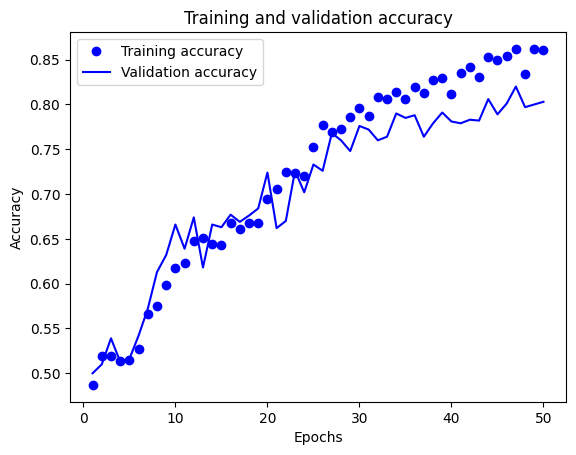

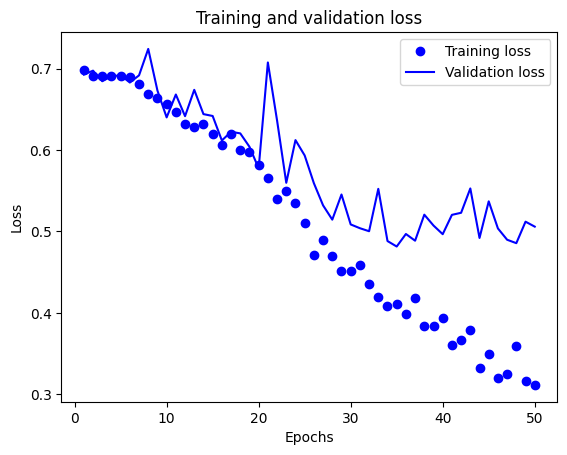

In [17]:
accuracy = hist.history["accuracy"]
val = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [18]:
testaccu = keras.models.load_model(
"convnet_from_scratch_with_augmentation_info.keras")
test_loss, test_acc = testaccu.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 46ms/step - loss: 0.4406 - accuracy: 0.8020
Test accuracy: 0.802


### Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

**Increasing the training sample to 2000, keeping the Validation and test sets the same as before(500 samples)**

In [19]:
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=org_dir / fname,
            dst=dir / fname)
make_subset("train", start_index=500, end_index=2500)
make_subset("validation", start_index=2500, end_index=3000)
make_subset("test", start_index=3000, end_index=3500)
input= keras.Input(shape=(180, 180, 3))
data_1 = augmentation_info(input)
data_1 = layers.Rescaling(1./255)(data_1)
data_1= layers.Conv2D(filters=32, kernel_size=3, activation="relu")(data_1)
data_1 = layers.MaxPooling2D(pool_size=2)(data_1)
data_1 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(data_1)
data_1= layers.MaxPooling2D(pool_size=2)(data_1)
data_1= layers.Conv2D(filters=128, kernel_size=3, activation="relu")(data_1)
data_1= layers.MaxPooling2D(pool_size=2)(data_1)
data_1= layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data_1)
data_1= layers.MaxPooling2D(pool_size=2)(data_1)
data_1= layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data_1)
data_1 = layers.Flatten()(data_1)
data_1= layers.Dropout(0.5)(data_1)
output = layers.Dense(1, activation="sigmoid")(data_1)
model = keras.Model(inputs=input, outputs=output)
model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])
callback = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation_info.keras",
save_best_only=True,
monitor="val_loss")
]
hist = model.fit(
train_data,
epochs=50,
validation_data=valid_data,
callbacks=callback)

Epoch 1/50
63/63 [==============================] - 6s 64ms/step - loss: 0.6958 - accuracy: 0.5035 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 5s 72ms/step - loss: 0.6917 - accuracy: 0.5175 - val_loss: 0.6909 - val_accuracy: 0.5680
Epoch 3/50
63/63 [==============================] - 7s 102ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 4/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6927 - accuracy: 0.5195 - val_loss: 0.6862 - val_accuracy: 0.5310
Epoch 5/50
63/63 [==============================] - 6s 85ms/step - loss: 0.6933 - accuracy: 0.5235 - val_loss: 0.6869 - val_accuracy: 0.5400
Epoch 6/50
63/63 [==============================] - 6s 87ms/step - loss: 0.6800 - accuracy: 0.5770 - val_loss: 0.6851 - val_accuracy: 0.5310
Epoch 7/50
63/63 [==============================] - 4s 61ms/step - loss: 0.6768 - accuracy: 0.5710 - val_loss: 0.6744 - val_accuracy: 0.5930
Epoch 8/50
6

**Curves of loss and accuracy during training**





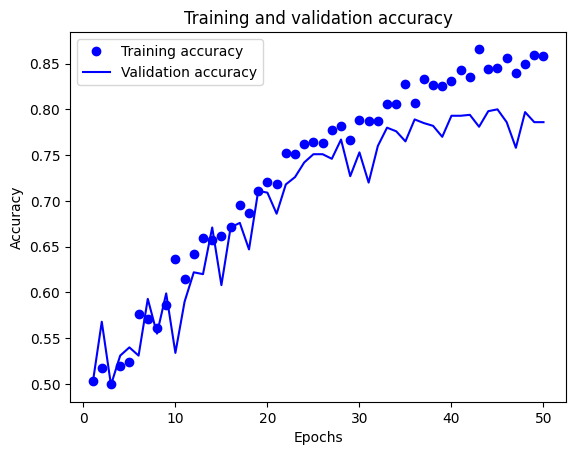

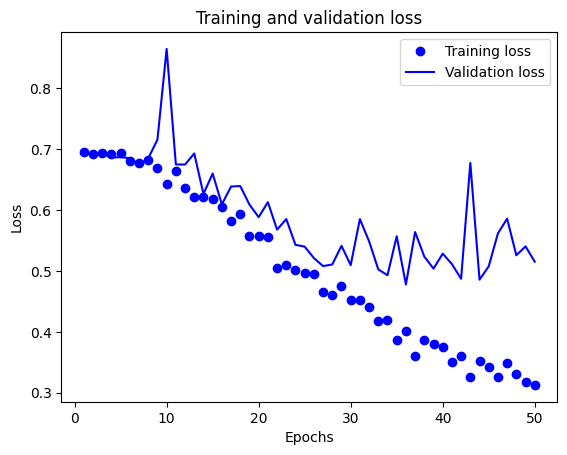

In [20]:
accuracy = hist.history["accuracy"]
validation = hist.history["val_accuracy"]
loss = hist.history["loss"]
valloss = hist.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, validation, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, valloss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [21]:
testacc = keras.models.load_model(
"convnet_from_scratch_with_augmentation_info.keras")
test_loss, test_acc = testacc.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 30ms/step - loss: 0.4511 - accuracy: 0.7940
Test accuracy: 0.794


### Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

**Instantiating the VGG16 convolutional base**

In [22]:
convoluted = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False,
input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [23]:
convoluted.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**pretrained model for feature extraction without data augmentation**

In [24]:
def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convoluted.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return np.concatenate(all_feature), np.concatenate(all_label)
train_features, train_labels = get_features_and_labels(train_data)
val_features, val_labels = get_features_and_labels(valid_data)
test_features, test_labels = get_features_and_labels(test_data)

1/1 [==============================] - 0s 18ms/step


In [25]:
train_features.shape

(2000, 5, 5, 512)

**Model Fitting**

In [26]:
input = keras.Input(shape=(5, 5, 512))
data_2 = layers.Flatten()(input)
data_2 = layers.Dense(256)(data_2)
data_2 = layers.Dropout(0.5)(data_2)
out = layers.Dense(1, activation="sigmoid")(data_2)
model = keras.Model(input, out)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callback= [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
train_features, train_labels,
epochs=50,
validation_data=(val_features, val_labels),
callbacks=callback)

Epoch 1/50
63/63 [==============================] - 2s 12ms/step - loss: 13.8777 - accuracy: 0.9250 - val_loss: 4.7103 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 0s 6ms/step - loss: 3.0592 - accuracy: 0.9755 - val_loss: 5.2368 - val_accuracy: 0.9740
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 1.2328 - accuracy: 0.9880 - val_loss: 15.2168 - val_accuracy: 0.9440
Epoch 4/50
63/63 [==============================] - 0s 6ms/step - loss: 1.1525 - accuracy: 0.9920 - val_loss: 8.1107 - val_accuracy: 0.9590
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 0.8188 - accuracy: 0.9905 - val_loss: 4.9997 - val_accuracy: 0.9760
Epoch 6/50
63/63 [==============================] - 0s 7ms/step - loss: 0.6973 - accuracy: 0.9940 - val_loss: 6.1111 - val_accuracy: 0.9690
Epoch 7/50
63/63 [==============================] - 0s 6ms/step - loss: 0.2487 - accuracy: 0.9950 - val_loss: 7.0332 - val_accuracy: 0.9700
Epoch 8/50
63/63 

**Curves of loss and accuracy during training**

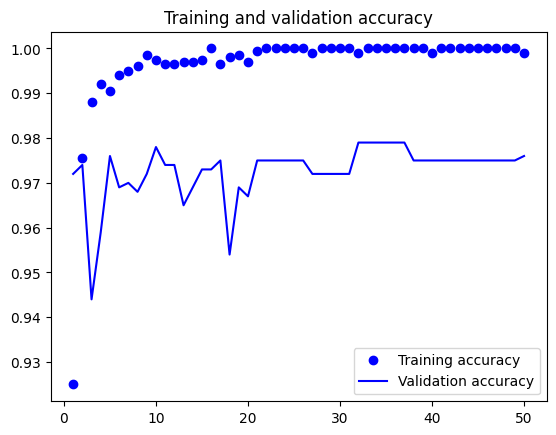

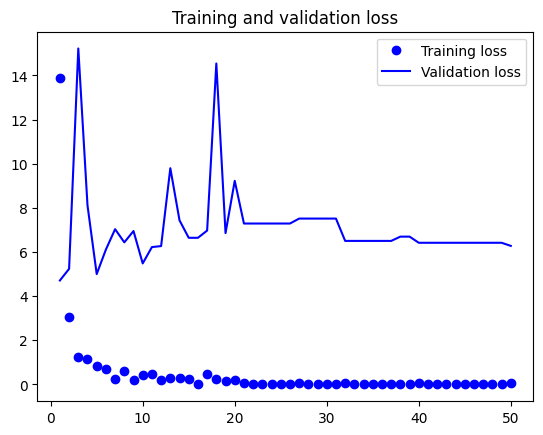

In [27]:
accur = history.history["accuracy"]
valac= history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accur) + 1)
plt.plot(epochs, accur, "bo", label="Training accuracy")
plt.plot(epochs, valac, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Freezing and Unfreezing the Pre-trained Convolutional Base**

In [28]:
convoluted = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
convoluted.trainable = False
convoluted.trainable = True
print("This is the number of trainable weights "
"before freezing the conv base:", len(convoluted.trainable_weights))
convoluted.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(convoluted.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Model is now performing with a classifier and agumentation to convulation base**

In [29]:
augmented= keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
input = keras.Input(shape=(180, 180, 3))
data_3= augmented(input)
data_3=keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(data_3)
data_3= convoluted(data_3)
data_3 = layers.Flatten()(data_3)
data_3 = layers.Dense(256)(data_3)
data_3= layers.Dropout(0.5)(data_3)
outputs = layers.Dense(1, activation="sigmoid")(data_3)
model = keras.Model(input, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callback = [
keras.callbacks.ModelCheckpoint(
filepath="features_extraction_with_augmentation2.keras",
save_best_only=True,
monitor="val_loss"
)
]
history= model.fit(
train_data,
epochs=100,
validation_data=valid_data,
callbacks=callback
)

Epoch 1/100
63/63 [==============================] - 14s 196ms/step - loss: 15.6539 - accuracy: 0.8985 - val_loss: 4.5115 - val_accuracy: 0.9660
Epoch 2/100
63/63 [==============================] - 11s 172ms/step - loss: 6.7755 - accuracy: 0.9400 - val_loss: 4.0749 - val_accuracy: 0.9770
Epoch 3/100
63/63 [==============================] - 10s 159ms/step - loss: 6.4133 - accuracy: 0.9505 - val_loss: 7.9471 - val_accuracy: 0.9570
Epoch 4/100
63/63 [==============================] - 10s 158ms/step - loss: 4.7811 - accuracy: 0.9655 - val_loss: 9.6755 - val_accuracy: 0.9520
Epoch 5/100
63/63 [==============================] - 12s 191ms/step - loss: 3.3019 - accuracy: 0.9680 - val_loss: 3.5963 - val_accuracy: 0.9800
Epoch 6/100
63/63 [==============================] - 10s 152ms/step - loss: 3.5062 - accuracy: 0.9680 - val_loss: 8.2014 - val_accuracy: 0.9590
Epoch 7/100
63/63 [==============================] - 11s 161ms/step - loss: 3.4003 - accuracy: 0.9690 - val_loss: 3.5877 - val_accuracy

**Curves of loss and accuracy during training**





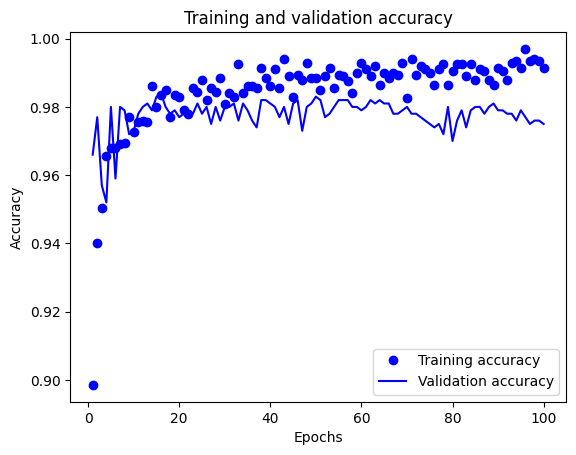

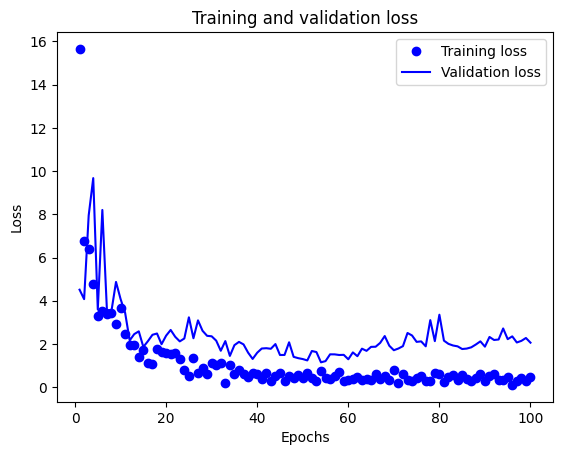

In [30]:
accuracy_1 = history.history["accuracy"]
validation= history.history["val_accuracy"]
loss = history.history["loss"]
valloss = history.history["val_loss"]
epochs = range(1, len(accuracy_1) + 1)
plt.plot(epochs, accuracy_1, "bo", label="Training accuracy")
plt.plot(epochs, validation, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, valloss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [31]:
tesaccuracy = keras.models.load_model(
"features_extraction_with_augmentation2.keras",safe_mode=False)
test_loss, test_acc = tesaccuracy.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 95ms/step - loss: 2.8497 - accuracy: 0.9670
Test accuracy: 0.967


**Fine-tuning a pretrained model**

In [32]:
convoluted.trainable = True
for layer in convoluted.layers[:-4]:
    layer.trainable = False

model.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
metrics=["accuracy"])
callback = [
keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
historytuning = model.fit(
train_data,
epochs=50,
validation_data=valid_data,
callbacks=callback)

Epoch 1/50
63/63 [==============================] - 14s 190ms/step - loss: 0.2360 - accuracy: 0.9925 - val_loss: 2.1644 - val_accuracy: 0.9780
Epoch 2/50
63/63 [==============================] - 12s 188ms/step - loss: 0.2228 - accuracy: 0.9930 - val_loss: 1.7981 - val_accuracy: 0.9770
Epoch 3/50
63/63 [==============================] - 12s 182ms/step - loss: 0.4866 - accuracy: 0.9935 - val_loss: 3.1030 - val_accuracy: 0.9750
Epoch 4/50
63/63 [==============================] - 13s 209ms/step - loss: 0.3216 - accuracy: 0.9940 - val_loss: 1.7541 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 13s 196ms/step - loss: 0.1992 - accuracy: 0.9950 - val_loss: 1.8541 - val_accuracy: 0.9780
Epoch 6/50
63/63 [==============================] - 11s 169ms/step - loss: 0.2046 - accuracy: 0.9940 - val_loss: 1.8240 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 11s 176ms/step - loss: 0.1288 - accuracy: 0.9960 - val_loss: 1.8414 - val_accuracy: 0.9760

**Curves of loss and accuracy during training**





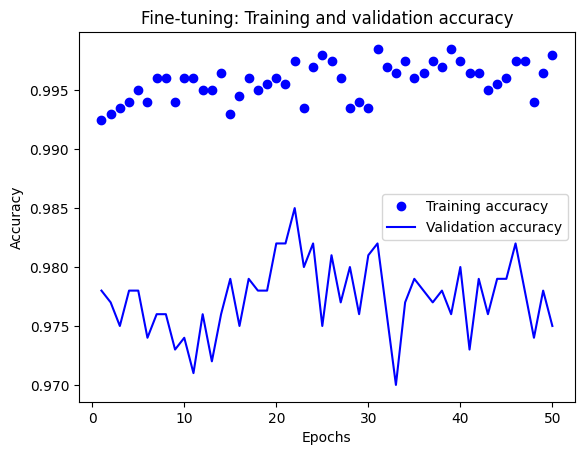

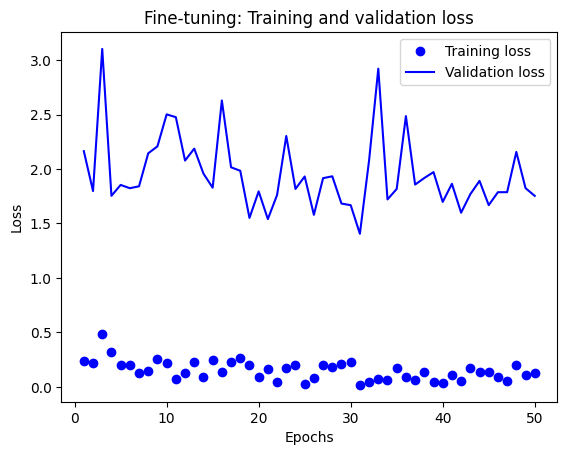

In [33]:
accuracy_2= historytuning.history["accuracy"]
val_accuracy_tune = historytuning.history["val_accuracy"]
loss_tune = historytuning.history["loss"]
val_loss = historytuning.history["val_loss"]
epochs = range(1, len(accuracy_2) + 1)

plt.plot(epochs, accuracy_2, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy_tune, "b", label="Validation accuracy")
plt.title("Fine-tuning: Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss_tune, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Fine-tuning: Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [34]:
tesaccuracy = keras.models.load_model(
"fine_tuning.keras",safe_mode=False)
test_loss, test_acc = tesaccuracy.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 99ms/step - loss: 3.0953 - accuracy: 0.9770
Test accuracy: 0.977
